In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import collections
import copy

In [51]:
from scipy.optimize import curve_fit
from srttools.fit import *

def offset_fit(x, y, offset_start=0, return_err=False):
    """Fit a constant offset to the data.

    Parameters
    ----------
    x : array-like
    y : array-like
    offset_start : float
        Constant offset, initial value

    Returns
    -------
    offset : float
        Fitted offset
    """
    par, _ = curve_fit(offset, x, y, [offset_start],
                       maxfev=6000)
    if return_err:
        warnings.warn("return_err not implemented yet in offset_fit")
        return par[0], None
    else:
        return par[0]
    

def offset_fit_with_median(x, y, offset_start=0, return_err=False):
    """Fit a constant offset to the data.

    Parameters
    ----------
    x : array-like
    y : array-like
    offset_start : float
        Constant offset, initial value

    Returns
    -------
    offset : float
        Fitted offset
    """
    res = np.median(y)
    if return_err:
        warnings.warn("return_err not implemented yet in offset_fit")
        return res, None
    else:
        return res


def _als(y, lam, p, niter=10):
    """Baseline Correction with Asymmetric Least Squares Smoothing.

    Modifications to the routine from Eilers & Boelens 2005
    https://www.researchgate.net/publication/
        228961729_Technical_Report_Baseline_Correction_with_
        Asymmetric_Least_Squares_Smoothing
    The Python translation is partly from
    http://stackoverflow.com/questions/29156532/
        python-baseline-correction-library

    Parameters
    ----------
    y : array-like
        the data series corresponding to x
    lam : float
        the lambda parameter of the ALS method. This control how much the
        baseline can adapt to local changes. A higher value corresponds to a
        stiffer baseline
    p : float
        the asymmetry parameter of the ALS method. This controls the overall
        slope tollerated for the baseline. A higher value correspond to a
        higher possible slope

    Other parameters
    ----------------
    niter : int
        The number of iterations to perform

    Returns
    -------
    z : array-like, same size as y
        Fitted baseline.
    """
    from scipy import sparse
    L = len(y)
    D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for _ in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = sparse.linalg.spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

    
def baseline_als(x, y, lam=None, p=None, niter=10, return_baseline=False,
                 offset_correction=True, mask=None,
                 outlier_purging=True):
    """Baseline Correction with Asymmetric Least Squares Smoothing.

    Parameters
    ----------
    x : array-like
        the sample time/number/position
    y : array-like
        the data series corresponding to x
    lam : float
        the lambda parameter of the ALS method. This control how much the
        baseline can adapt to local changes. A higher value corresponds to a
        stiffer baseline
    p : float
        the asymmetry parameter of the ALS method. This controls the overall
        slope tollerated for the baseline. A higher value correspond to a
        higher possible slope

    Other Parameters
    ----------------
    niter : int
        The number of iterations to perform
    return_baseline : bool
        return the baseline?
    offset_correction : bool
        also correct for an offset to align with the running mean of the scan
    outlier_purging : bool
        Purge outliers before the fit?
    mask : array of bools
        Mask indicating the good x and y data. True for good, False for bad

    Returns
    -------
    y_subtracted : array-like, same size as y
        The initial time series, subtracted from the trend
    baseline : array-like, same size as y
        Fitted baseline. Only returned if return_baseline is True
    """

    if not isinstance(outlier_purging, collections.Iterable):
        outlier_purging = (outlier_purging, outlier_purging)
    if lam is None:
        lam = 1e11
    if p is None:
        p = 0.001

    N = len(y)
    approx_m = (np.median(y[-20:]) - np.median(y[:20])) / N
    y = y - approx_m * np.arange(N)
    y_mod = purge_outliers(copy.deepcopy(y), up=outlier_purging[0],
                           down=outlier_purging[1],
                           mask=mask)

    z = _als(y_mod, lam, p, niter=niter)

    ysub = y_mod - z
    offset = 0
    if offset_correction:
        std = ref_std(ysub, np.max([len(y) // 20, 20]))

        good = np.abs(ysub) < 10 * std

        offset = offset_fit(x[good], ysub[good], 0)

    if return_baseline:
        return y - z - offset, z + offset
    else:
        return y - z - offset

    
def baseline_als_offset_median(x, y, lam=None, p=None, niter=10, return_baseline=False,
                 offset_correction=True, mask=None,
                 outlier_purging=True):
    """Baseline Correction with Asymmetric Least Squares Smoothing.

    Parameters
    ----------
    x : array-like
        the sample time/number/position
    y : array-like
        the data series corresponding to x
    lam : float
        the lambda parameter of the ALS method. This control how much the
        baseline can adapt to local changes. A higher value corresponds to a
        stiffer baseline
    p : float
        the asymmetry parameter of the ALS method. This controls the overall
        slope tollerated for the baseline. A higher value correspond to a
        higher possible slope

    Other Parameters
    ----------------
    niter : int
        The number of iterations to perform
    return_baseline : bool
        return the baseline?
    offset_correction : bool
        also correct for an offset to align with the running mean of the scan
    outlier_purging : bool
        Purge outliers before the fit?
    mask : array of bools
        Mask indicating the good x and y data. True for good, False for bad

    Returns
    -------
    y_subtracted : array-like, same size as y
        The initial time series, subtracted from the trend
    baseline : array-like, same size as y
        Fitted baseline. Only returned if return_baseline is True
    """

    if not isinstance(outlier_purging, collections.Iterable):
        outlier_purging = (outlier_purging, outlier_purging)
    if lam is None:
        lam = 1e11
    if p is None:
        p = 0.001
    N = len(y)
    approx_m = (np.median(y[-20:]) - np.median(y[:20])) / N
    y = y - approx_m * np.arange(N)
    y_mod = purge_outliers(y, up=outlier_purging[0],
                           down=outlier_purging[1],
                           mask=mask)

    z = _als(y_mod, lam, p, niter=niter)

    ysub = y_mod - z
    offset = 0
    if offset_correction:
        std = ref_std(ysub, np.max([len(y) // 20, 20]))

        good = np.abs(ysub) < 10 * std

        offset = offset_fit_with_median(x[good], ysub[good], 0)

    if return_baseline:
        return y - z - offset, z + offset
    else:
        return y - z - offset


In [60]:
def _test_shape(x):
    return np.exp(-(x - 50) ** 2 / 50)

series = np.random.normal(0, 0.1, 1000)
t = np.arange(0, len(series)/10, 0.1)
x = np.arange(0, len(series)) * 0.1
y = np.copy(series) + _test_shape(x) + x * 6 + 20


<IPython.core.display.Javascript object>


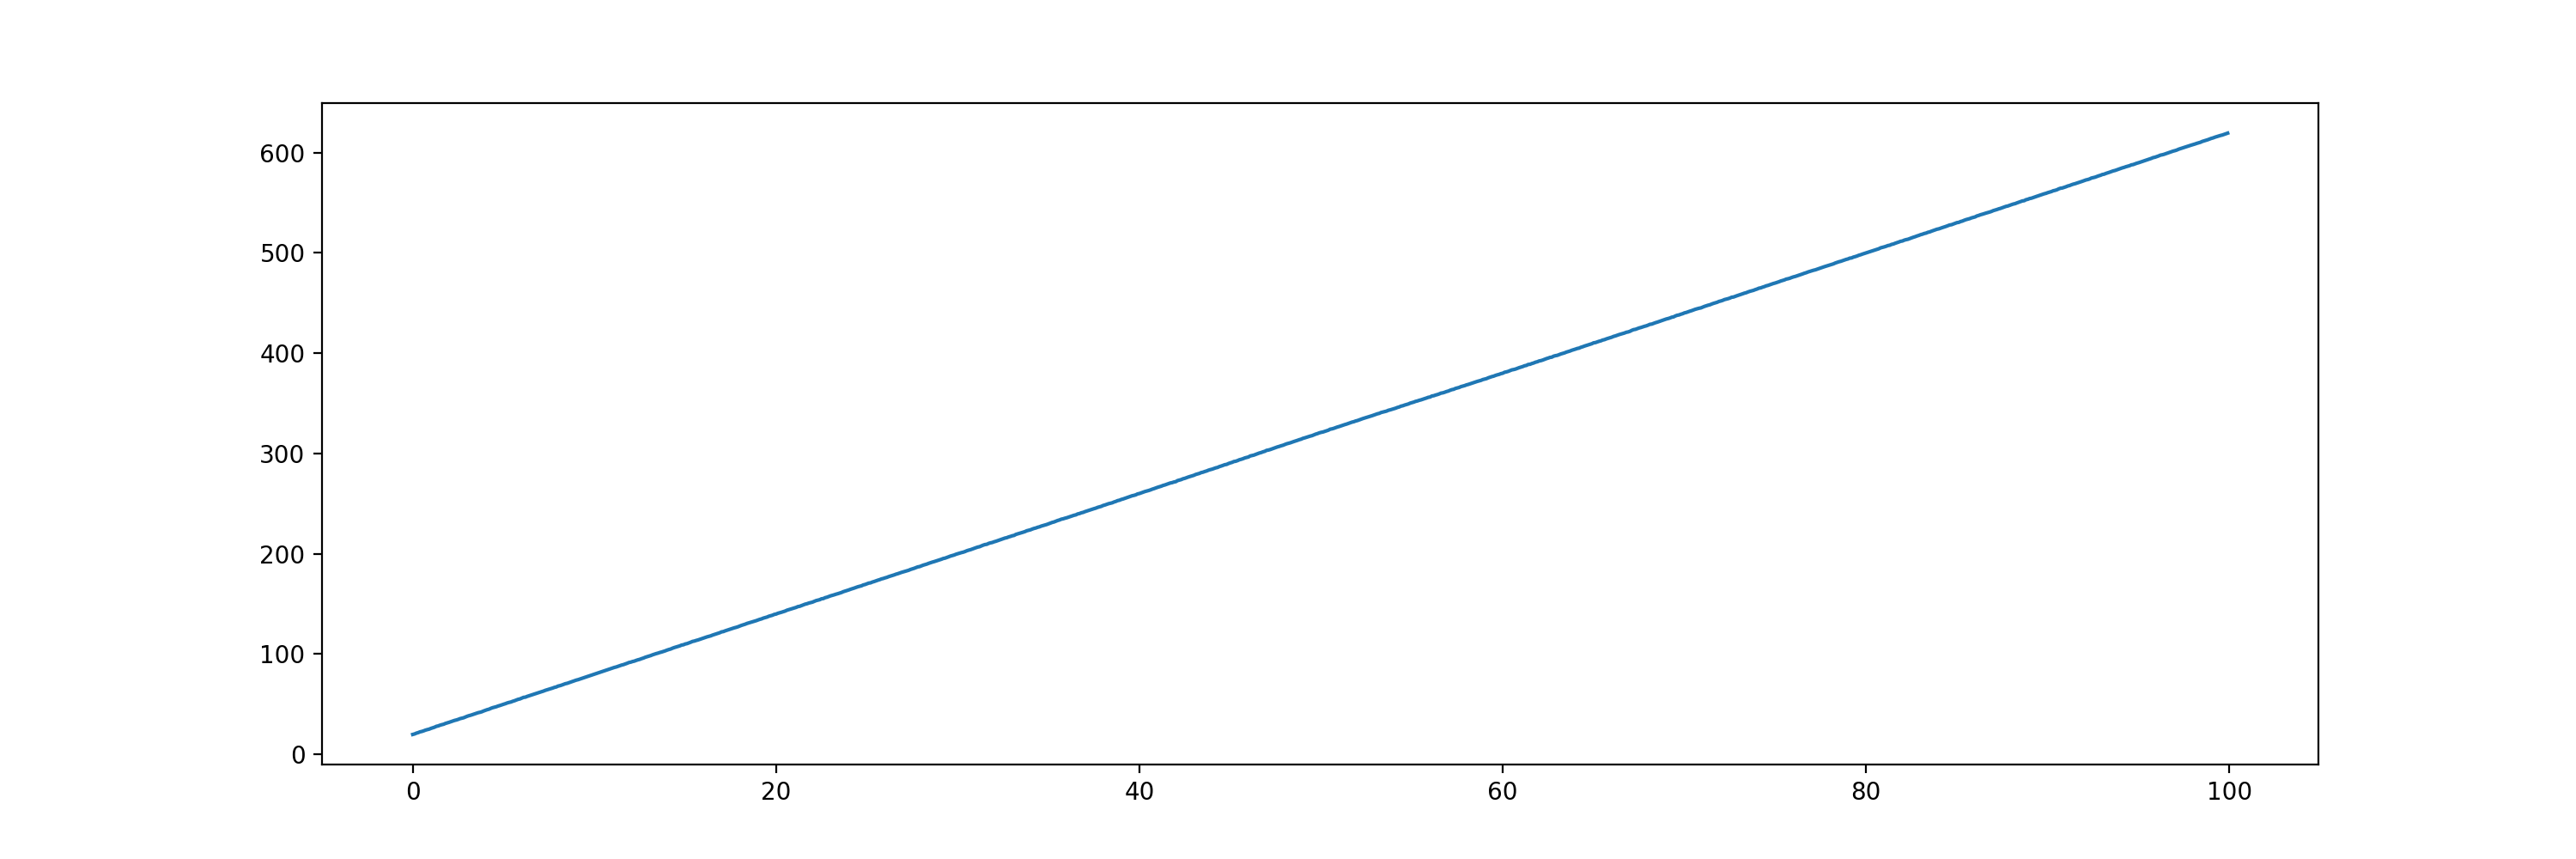

<IPython.core.display.Javascript object>


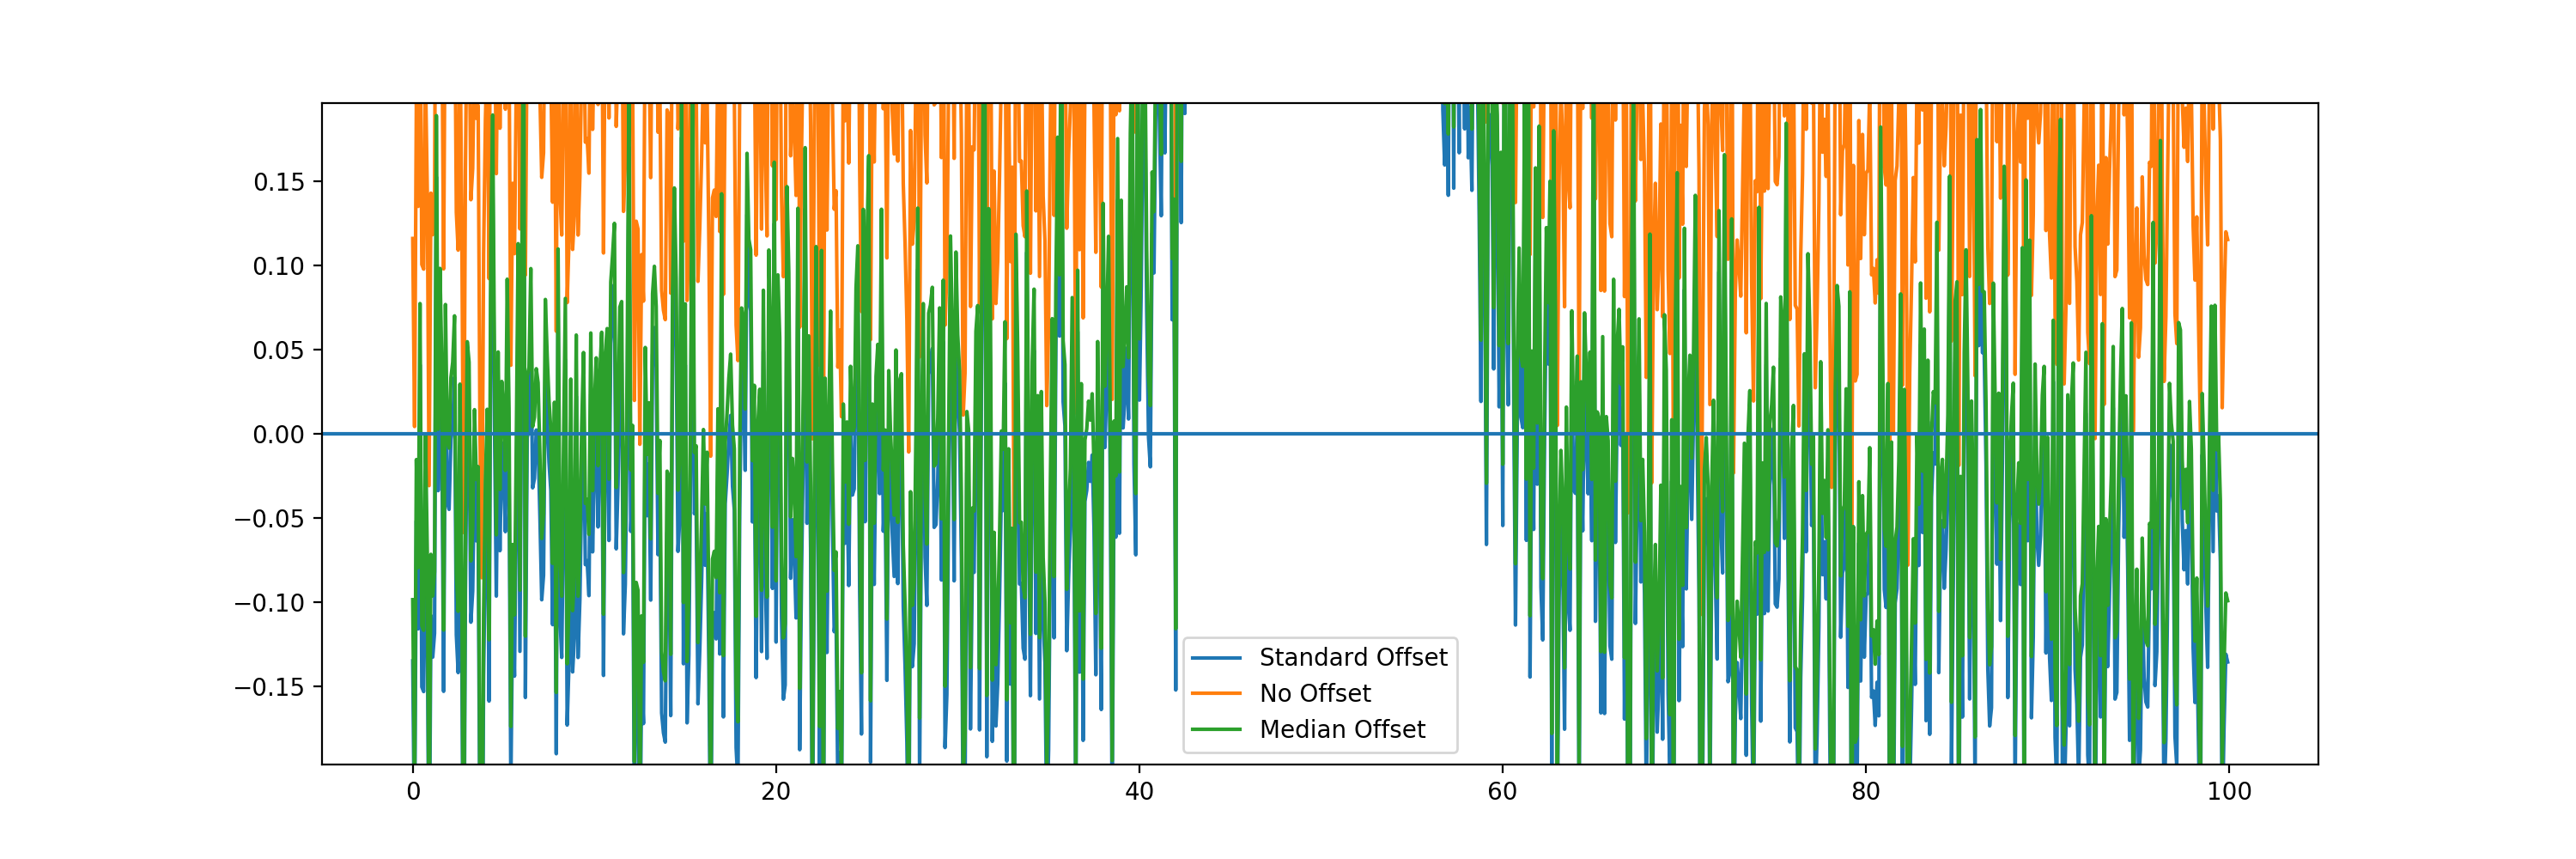

In [61]:
plt.figure(figsize=(15, 5))
plt.plot(x, y)
plt.figure(figsize=(15, 5))
plt.plot(x, baseline_als(x, y, offset_correction=True), label='Standard Offset')
plt.plot(x, baseline_als(x, y, offset_correction=False), label='No Offset')
plt.plot(x, baseline_als_offset_median(x, y, offset_correction=True), label='Median Offset')
std = np.std(np.diff(y)) / np.sqrt(2)
plt.ylim([- std * 2, std * 2])
plt.axhline(0)
plt.legend()

In [62]:
def simulate_and_test_best_offset(baseline_m=6, noise=1, signal=100, plot=False, label=None):
    if label is None:
        label = '{:0>10}'.format(np.random.randint(0, 10000000))
    def _test_shape(x):
        return np.exp(-(x - 50) ** 2 / 50)
    series = np.random.normal(0, noise, 1000)
    t = np.arange(0, len(series)/10, 0.1)
    x = np.arange(0, len(series)) * 0.1
    y = np.copy(series) + signal * _test_shape(x) + x * baseline_m + 20
    y_bsub_standard = baseline_als(x, y, offset_correction=True)
    y_bsub_median = baseline_als_offset_median(x, y, offset_correction=True)
    
    y_bsub_standard_filt = np.concatenate((y_bsub_standard[:200], y_bsub_standard[-200:]))
    y_bsub_median_filt = np.concatenate((y_bsub_median[:200], y_bsub_median[-200:]))
    rms_standard = np.sqrt(np.sum(y_bsub_standard_filt ** 2) / (len(y_bsub_standard_filt) -1))
    rms_median = np.sqrt(np.sum(y_bsub_median_filt ** 2) / (len(y_bsub_median_filt)-1))
    reference_rms = np.std(np.diff(y_bsub_standard_filt)) / np.sqrt(2)
    if plot or rms_median / reference_rms > 2:
        fig = plt.figure(figsize=(15, 5))
        plt.plot(x, y_bsub_standard, label='Standard Offset')
        plt.plot(x, y_bsub_median, label='Median Offset')
        std = np.std(np.diff(y)) / np.sqrt(2)
        plt.ylim([- std * 2, std * 2])
        plt.axhline(0)
        plt.legend()
        plt.savefig(label + '.png')
        plt.close(fig)
    return rms_standard, rms_median, reference_rms

<IPython.core.display.Javascript object>


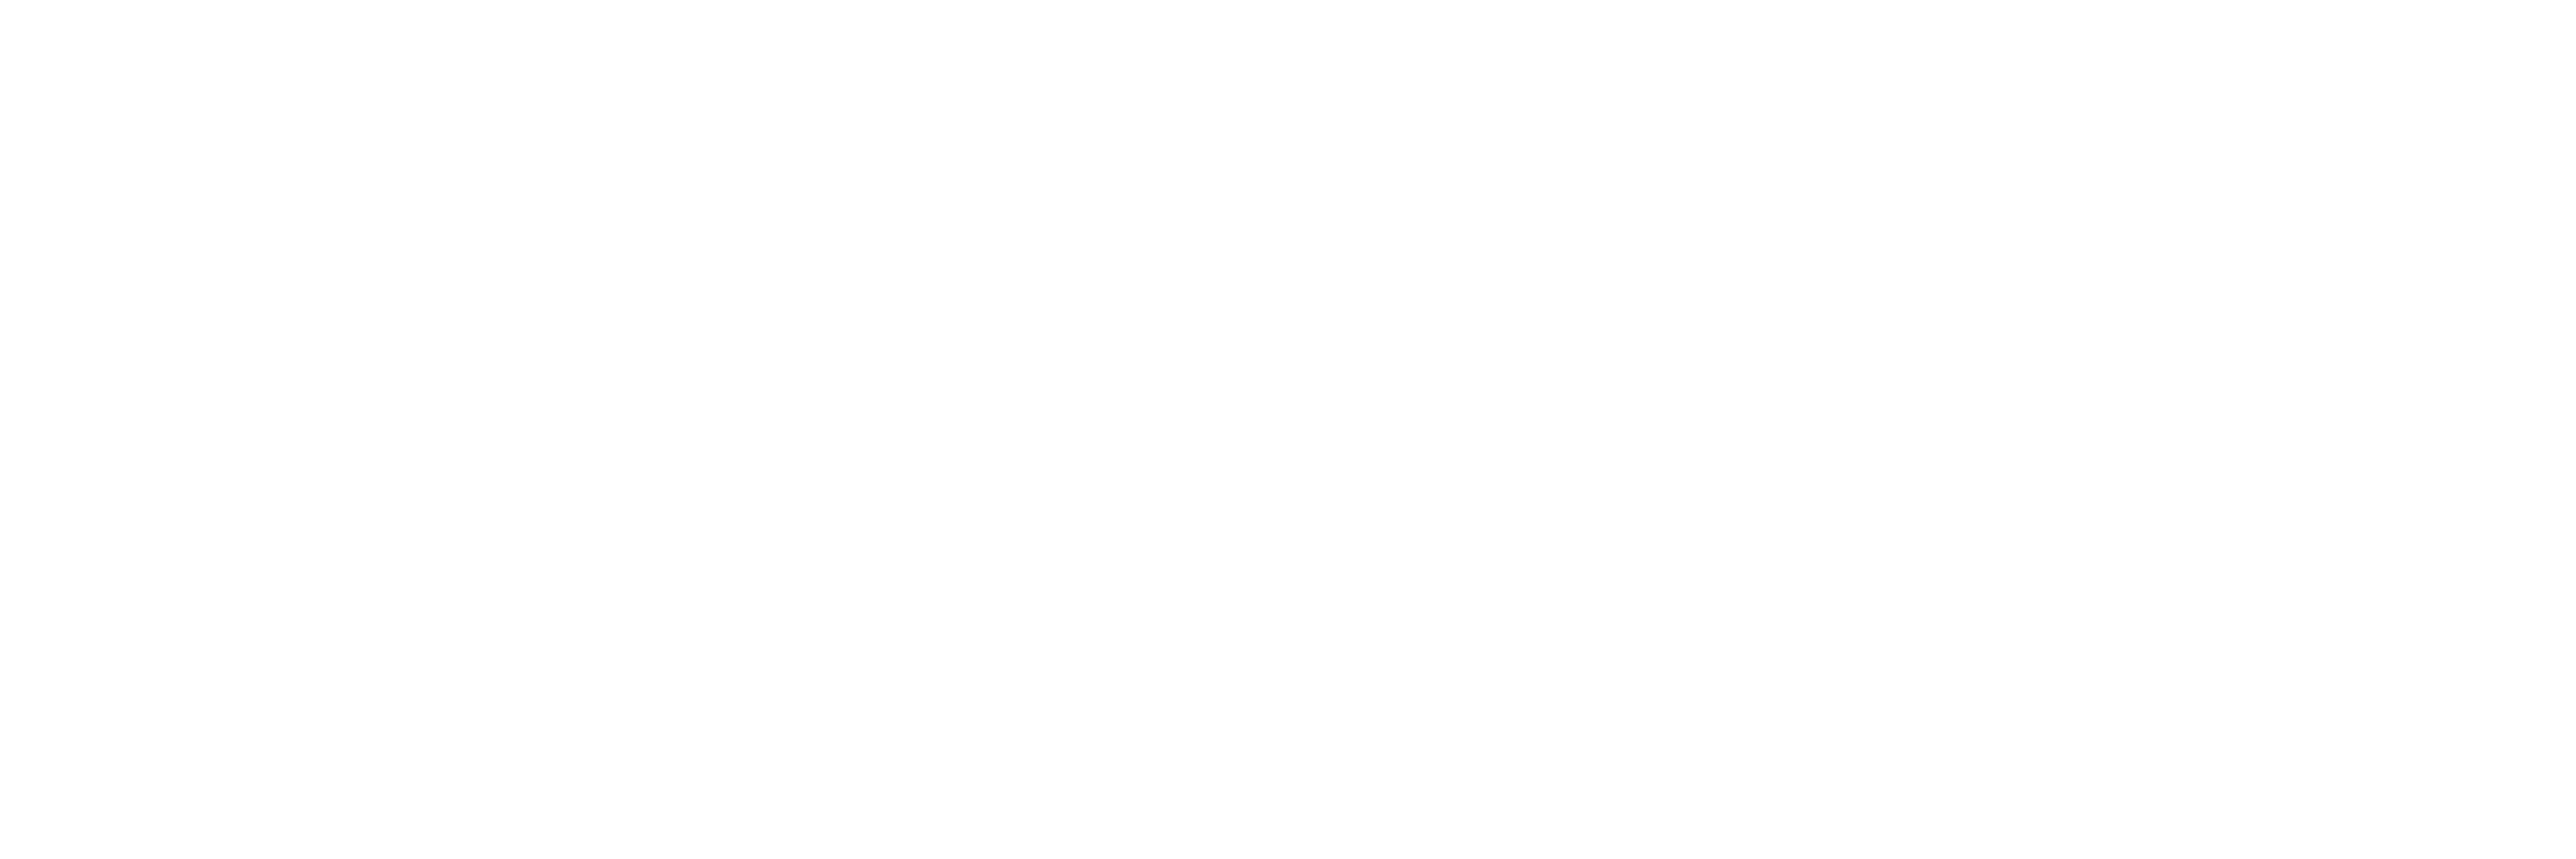

(1.0973185836741248, 1.0302265750920279, 1.0080665404192097)

In [63]:
simulate_and_test_best_offset(plot=True)

In [55]:
import tqdm
with open('table_offset.csv', 'w') as fobj:
    print('m,noise,signal,rms_st,rms_med,ref_rms', file=fobj)
    
    for i in tqdm.tqdm(range(1000)):
        m = np.random.uniform(-6, 6)
        noise = np.random.uniform(0, 10)
        signal = np.random.uniform(0, 100)
        rms_standard, rms_median, reference_rms, = \
            simulate_and_test_best_offset(baseline_m=m, noise=noise, signal=signal, plot=False)
        line = ','.join([str(i) for i in [m,noise,signal,rms_standard,rms_median,reference_rms]])
        print(line, file=fobj)

    

100%|██████████| 1000/1000 [01:01<00:00, 16.32it/s]


In [56]:
import pandas as pd
table = pd.read_csv('table_offset.csv')

In [57]:
table

,m,noise,signal,rms_st,rms_med,ref_rms
0,-5.190913,9.482810,9.699259,10.770827,10.753981,10.253475
1,-2.898899,8.736062,45.778030,10.445068,9.213728,8.378304
2,-2.157702,3.412237,95.671522,3.745873,3.435633,3.287243
3,4.599607,8.940895,86.404409,11.504776,10.004095,9.749268
4,-2.847355,6.996934,78.933908,8.262269,7.490805,6.965474
5,2.915978,4.620541,91.916165,4.954438,4.591224,4.435472
6,0.094161,6.373136,34.341143,8.173054,7.302045,6.927112
7,1.713551,0.805785,9.272374,1.003067,0.846751,0.795158
8,-4.096060,8.661951,20.545115,9.301600,9.201782,9.397630
9,5.633272,0.556761,30.685438,0.619803,0.583837,0.588996


In [58]:
table['snr'] = table['signal'] / table['noise']
table['med_ratio'] = table['rms_med'] / table['ref_rms']
table['st_ratio'] = table['rms_st'] / table['ref_rms']
table['med_is_better'] = table['med_ratio'] < table['st_ratio']


<IPython.core.display.Javascript object>


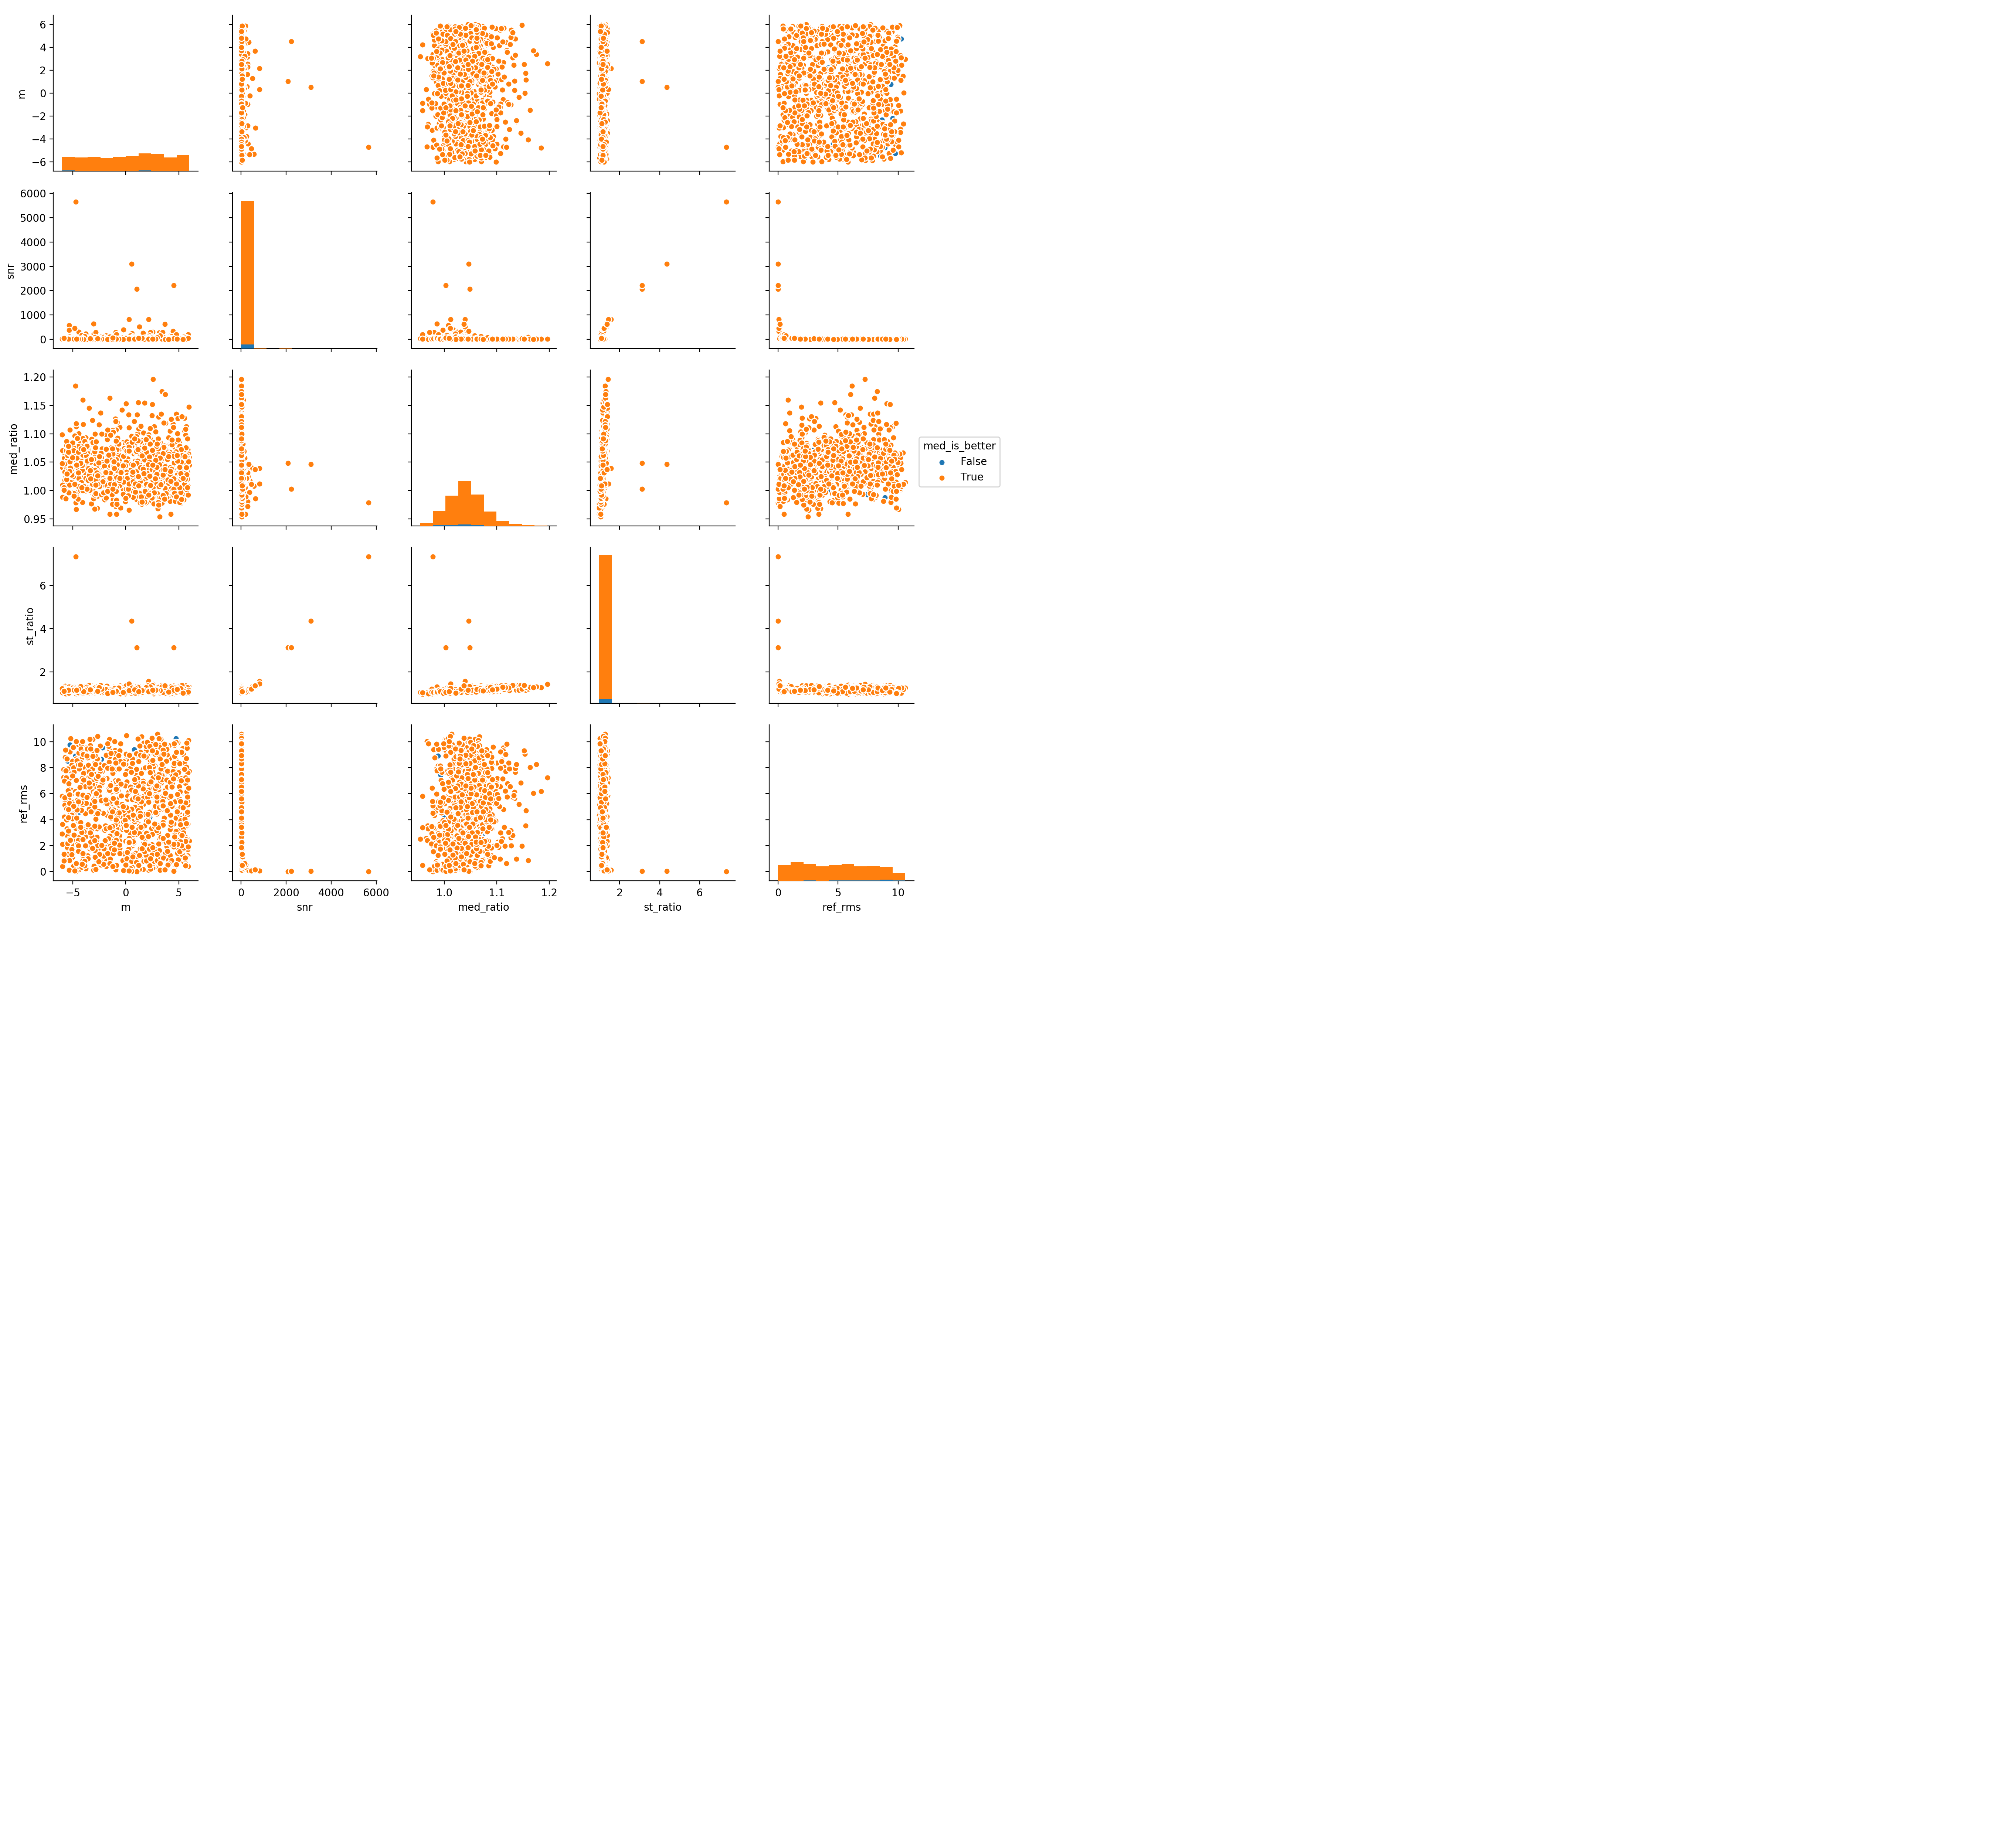

In [59]:
from seaborn import pairplot

pairplot(table, vars=["m", "snr", "med_ratio", "st_ratio", "ref_rms"], hue='med_is_better')

Basically, calculating the offset with the median is _always_ better.

In [68]:
def fit_baseline_plus_bell(x, y, ye=None, kind='gauss'):
    """Fit a function composed of a linear baseline plus a bell function.

    Parameters
    ----------
    x : array-like
        the sample time/number/position
    y : array-like
        the data series corresponding to x

    Other parameters
    ----------------
    ye : array-like
        the errors on the data series
    kind: str
        Can be 'gauss' or 'lorentz'

    Returns
    -------
    mod_out : ``Astropy.modeling.model`` object
        The fitted model
    fit_info : dict
        Fit info from the Astropy fitting routine.
    """
    if kind not in ['gauss', 'lorentz']:
        raise ValueError('kind has to be one of: gauss, lorentz')
    from astropy.modeling import models, fitting

    approx_m = (np.median(y[-20:]) - np.median(y[:20])) / \
               (np.mean(x[-20:]) - np.mean(x[:20]))

    base = models.Linear1D(slope=approx_m, intercept=np.min(y), name='Baseline')

    xrange = np.max(x) - np.min(x)
    yrange = np.max(y) - np.min(y)

    if kind == 'gauss':
        bell = models.Gaussian1D(mean=np.mean(x), stddev=xrange / 20,
                                 amplitude=yrange, name='Bell')
        bell.amplitude.bounds = (0, None)
        bell.mean.bounds = (None, None)
        bell.stddev.bounds = (0, None)
        # max_name = 'mean'
    elif kind == 'lorentz':
        bell = models.Lorentz1D(x_0=np.mean(x), fwhm=xrange / 20,
                                amplitude=yrange, name='Bell')
        bell.amplitude.bounds = (0, None)
        bell.x_0.bounds = (None, None)
        bell.fwhm.bounds = (0, None)
        # max_name = 'x_0'

    mod_init = base + bell

    fit = fitting.LevMarLSQFitter()

    mod_out = fit(mod_init, x, y)

    return mod_out, fit.fit_info


5.9939484983906555
Model: CompoundModel2
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Linear1D(slope=5.9939485, intercept=20.04964428, name='Baseline')>

    [1]: <Gaussian1D(amplitude=599.5166061, mean=49.95, stddev=4.995, name='Bell')>
Parameters:
       slope_0        intercept_0    ...       mean_1           stddev_1    
    -------------- ----------------- ... ----------------- -----------------
    6.000281560228 19.97249205015111 ... 50.02639788322165 4.990585308080873


<IPython.core.display.Javascript object>


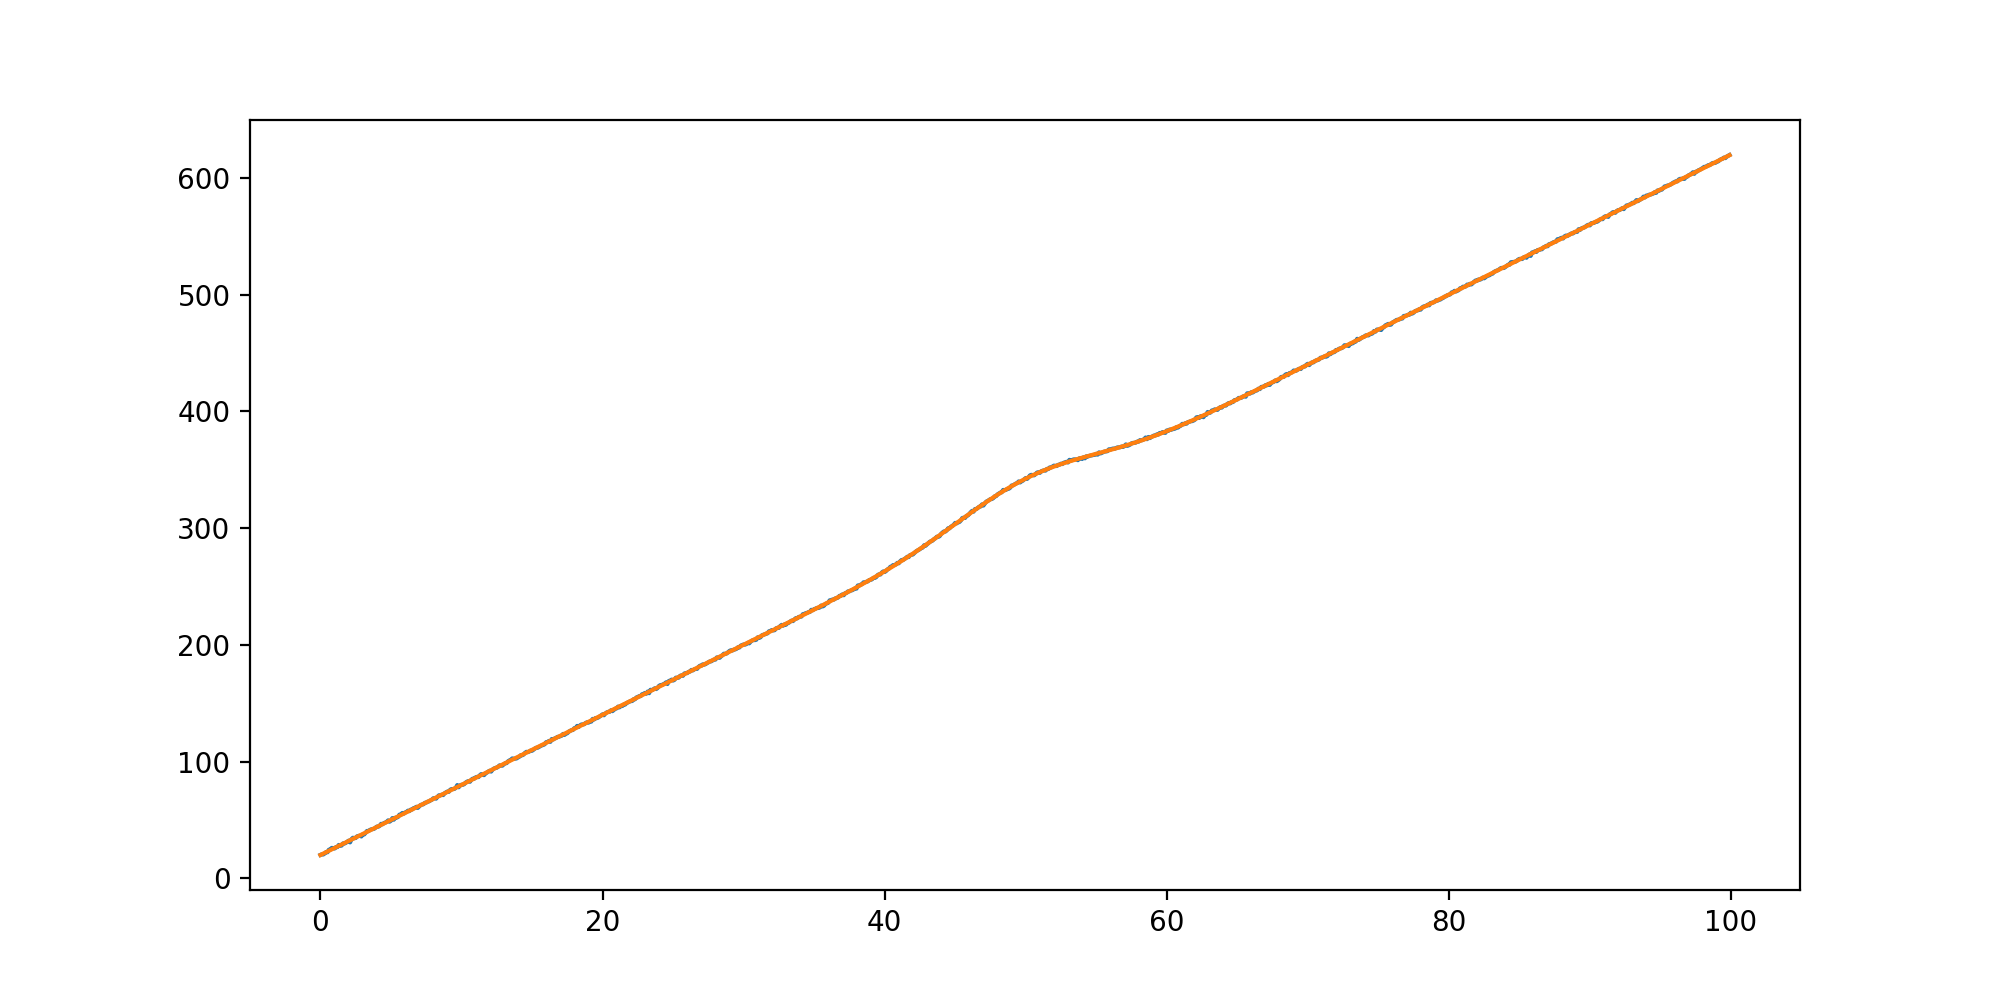

In [69]:
def _test_shape(x):
    return np.exp(-(x - 50) ** 2 / 50)
series = np.random.normal(0, noise, 1000)
t = np.arange(0, len(series)/10, 0.1)
x = np.arange(0, len(series)) * 0.1
y = np.copy(series) + signal * _test_shape(x) + x * 6 + 20
mod, _ = fit_baseline_plus_bell(x, y, kind='gauss')

plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.plot(x, mod(x))